# MaskFormer for semantic segmentation

MaskFormer is currently one of the most SOTA model in image segmentation

## Set-up environment
Using [Albumentations](https://github.com/albumentations-team/albumentations#spatial-level-transforms), for some data augmentation to make the model more robust.

In [8]:
# read data set
import os
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import cv2
import copy

def read_data(root_path):
    data = []
    img_paths = []
    labels = []
    for label in os.listdir(root_path):
        if ".ipynb_checkpoints" in label:
            continue
        for image in os.listdir(os.path.join(root_path, label) + "/image"):
            path_to_img = os.path.join(os.path.join(root_path, label) + "/image", image)
            path_to_label = os.path.join(os.path.join(root_path, label) + "/label", image)
            if ".ipynb_checkpoints" in image:
                continue
            if os.path.exists(path_to_img) and os.path.exists(path_to_label):
                # create a new dictionary for each image
                sample = dict()
                print(id(sample))
                sample['pixel_values'] = Image.open(path_to_img).convert('RGB')
                sample['label'] = Image.open(path_to_label).convert('L')
                sample['img_path'] = path_to_img
                sample['label_path'] = path_to_label
                print(sample['img_path'])
                data.append(copy.deepcopy(sample))
                img_paths.append(path_to_img)
                labels.append(label)

    # creating df
    data_frame = pd.DataFrame({'img_path': img_paths, 'label': labels})
    print('len of data:', len(data))
    return data, data_frame


# change file path for your work space
data,df = read_data("/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG")
            

136507690333696
/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG/High-grade IN/image/GT2012508-1-400-007.png
136507690333760
/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG/High-grade IN/image/GT2016846-3-400-001.png
136508233409472
/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG/High-grade IN/image/GT2017995-1-400-005.png
136507690334720
/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG/High-grade IN/image/GT2012436-1-400-003.png
136507690335232
/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG/High-grade IN/image/GTXC2015413-3-400-002.png
136507690794944
/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG/High-grade IN/image/GT2012196-2-400-001.png
136507690502272
/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG/High-grade IN/image/GTxc2012829-2-400-003.png
136508225340608
/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG/High-grade IN/image/GTXC2110128-2-400-006.png
136508225346560
/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG/High-grade IN/image/GTXC2015362-1-400-002.png
136507690794496
/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG/High-grade IN/image/GTDC21

In [ ]:
df

,img_path,label
0,/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG/High-...,High-grade IN
1,/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG/High-...,High-grade IN
2,/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG/High-...,High-grade IN
3,/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG/High-...,High-grade IN
4,/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG/High-...,High-grade IN
...,...,...
2221,/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG/Low-g...,Low-grade IN
2222,/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG/Low-g...,Low-grade IN
2223,/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG/Low-g...,Low-grade IN
2224,/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG/Low-g...,Low-grade IN


In [10]:
data[126]['img_path']

'/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG/High-grade IN/image/GTxc2012996-4-400-003.png'

In [11]:
!pip install -q git+https://github.com/huggingface/transformers.git

In [12]:
!pip install -q datasets

In [13]:
!pip install -q albumentations

## Load data


In [14]:
def color_palette():
    """Color palette that maps each class to RGB values.

    This one is actually taken from ADE20k.
    """
    return [[120, 120, 120],  [92, 0, 255]]

palette = color_palette()

## Create PyTorch Dataset


In [15]:
import numpy as np
from torch.utils.data import Dataset

class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, dataset, transform):
        """
        Args:
            dataset
        """
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        original_image = np.array(self.dataset[idx]['pixel_values'])
        original_segmentation_map = np.array(self.dataset[idx]['label'].convert('1'))*1

        transformed = self.transform(image=original_image, mask=original_segmentation_map)
        image, segmentation_map = transformed['image'], transformed['mask']

        # convert to C, H, W
        image = image.transpose(2,0,1)

        return image, segmentation_map, original_image, original_segmentation_map

In [16]:
import albumentations as A

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

#add more albumentation
train_transform = A.Compose([
    A.RandomCrop(width=224, height=224),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

test_transform = A.Compose([
    A.Resize(width=224, height=224),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),

])

## train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, df, stratify = df['label'],test_size=0.1, random_state=42)
data_train = [data[i] for i in X_train.index]
data_test = [data[i] for i in X_test.index]

train_dataset = ImageSegmentationDataset(data_train, transform=train_transform)
test_dataset = ImageSegmentationDataset(data_test, transform=test_transform)

In [17]:
image, segmentation_map, _, _ = train_dataset[80]

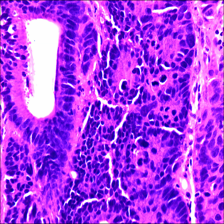

In [18]:
from PIL import Image

unnormalized_image = (image * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

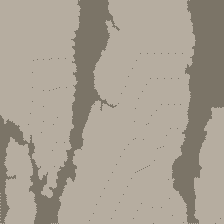

In [19]:
from PIL import Image


unnormalized_image = (segmentation_map * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [20]:
(segmentation_map * 255).astype(np.uint8)

array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [255, 255,   0, ..., 255, 255, 255]], dtype=uint8)

In [21]:
id2label = {0:'negative',1:'positive'}
labels = [id2label[label] for label in np.unique(segmentation_map)]
print(labels)

['negative', 'positive']


## Create PyTorch DataLoaders


In [22]:
from transformers import MaskFormerImageProcessor

# Create a preprocessor
preprocessor = MaskFormerImageProcessor(ignore_index=-1, reduce_labels=False, do_resize=False, do_rescale=False, do_normalize=False)

/opt/conda/lib/python3.10/site-packages/transformers/models/maskformer/image_processing_maskformer.py:429: FutureWarning: The `reduce_labels` argument is deprecated and will be removed in v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(


In [23]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    inputs = list(zip(*batch))
    images = inputs[0]
    segmentation_maps = inputs[1]
    # print(images[0].shape)
    # print(segmentation_maps[0].shape)
    # print(images[1].shape)
    # print(segmentation_maps[1].shape)
    # this function pads the inputs to the same size,
    # and creates a pixel mask
    # actually padding isn't required here since we are cropping
    batch = preprocessor(
        images,
        segmentation_maps=segmentation_maps,
        return_tensors="pt",
    )

    batch["original_images"] = inputs[2]
    batch["original_segmentation_maps"] = inputs[3]

    return batch

#change batch_size 
train_dataloader = DataLoader(train_dataset, batch_size=12, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

## Verify data (!!)



In [24]:
import torch

batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,v[0].shape)

pixel_values torch.Size([12, 3, 224, 224])
pixel_mask torch.Size([12, 224, 224])
mask_labels torch.Size([2, 224, 224])
class_labels torch.Size([2])
original_images (224, 224, 3)
original_segmentation_maps (224, 224)


In [25]:
pixel_values = batch["pixel_values"][0].numpy()
pixel_values.shape

(3, 224, 224)

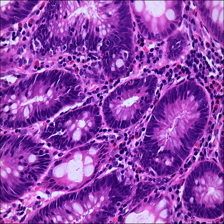

In [26]:
unnormalized_image = (pixel_values * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [27]:
id2label = {0:'negative',1:'positive'}

In [28]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Define model



In [29]:
from transformers import MaskFormerForInstanceSegmentation

# Replace the head of the pre-trained model
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-ade",
                                                          id2label=id2label,
                                                          ignore_mismatched_sizes=True)

Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at facebook/maskformer-swin-base-ade and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Compute initial loss


In [30]:
outputs = model(batch["pixel_values"],
                class_labels=batch["class_labels"],
                mask_labels=batch["mask_labels"])

In [31]:
outputs.loss

tensor([2.6079], grad_fn=<AddBackward0>)

## Train the model



In [32]:
!pip install -q evaluate

In [33]:
import evaluate

metric = evaluate.load("mean_iou")

In [34]:
import torch
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

running_loss = 0.0
num_samples = 0

#change epochs in here
epochs = 20
for epoch in range(epochs):
  print("Epoch:", epoch)
  model.train()
  for idx, batch in enumerate(tqdm(train_dataloader)):
      # Reset the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(
          pixel_values=batch["pixel_values"].to(device),
          mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
          class_labels=[labels.to(device) for labels in batch["class_labels"]],
      )

      # Backward propagation
      loss = outputs.loss
      loss.backward()

      batch_size = batch["pixel_values"].size(0)
      running_loss += loss.item()
      num_samples += batch_size

      if idx % 100 == 0:
        print("Loss:", running_loss/num_samples)

      # Optimization
      optimizer.step()

  model.eval()
  for idx, batch in enumerate(tqdm(test_dataloader)):
    if idx > 19:
      break

    pixel_values = batch["pixel_values"]

    # Forward pass
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values.to(device))

    # get original images
    original_images = batch["original_images"]
    target_sizes = [(image.shape[0], image.shape[1]) for image in original_images]
    # predict segmentation maps
    predicted_segmentation_maps = preprocessor.post_process_semantic_segmentation(outputs,
                                                                                  target_sizes=target_sizes)

    # get ground truth segmentation maps
    ground_truth_segmentation_maps = batch["original_segmentation_maps"]

    metric.add_batch(references=ground_truth_segmentation_maps, predictions=predicted_segmentation_maps)

  # NOTE this metric outputs a dict that also includes the mIoU per category as keys
  # so if you're interested, feel free to print them as well
  print("Mean IoU:", metric.compute(num_labels = len(id2label), ignore_index = -1)['mean_iou'])

Epoch: 0


  0%|          | 0/167 [00:00<?, ?it/s]

Loss: 0.21885677178700766
Loss: 0.1088235057619932


  0%|          | 0/28 [00:00<?, ?it/s]

Mean IoU: 0.8188128828245669
Epoch: 1


  0%|          | 0/167 [00:00<?, ?it/s]

Loss: 0.0923531608901012
Loss: 0.08050920997585516


  0%|          | 0/28 [00:00<?, ?it/s]

Mean IoU: 0.8551823060604595
Epoch: 2


  0%|          | 0/167 [00:00<?, ?it/s]

Loss: 0.07581172956199181
Loss: 0.07055786467343284


  0%|          | 0/28 [00:00<?, ?it/s]

Mean IoU: 0.8505890845900115
Epoch: 3


  0%|          | 0/167 [00:00<?, ?it/s]

Loss: 0.06824860898903133
Loss: 0.06544926268145444


  0%|          | 0/28 [00:00<?, ?it/s]

Mean IoU: 0.8562023762079037
Epoch: 4


  0%|          | 0/167 [00:00<?, ?it/s]

Loss: 0.06401316540042758
Loss: 0.062110233186047074


  0%|          | 0/28 [00:00<?, ?it/s]

Mean IoU: 0.8729299669901018
Epoch: 5


  0%|          | 0/167 [00:00<?, ?it/s]

Loss: 0.06099240577112729
Loss: 0.059379553674345525


  0%|          | 0/28 [00:00<?, ?it/s]

Mean IoU: 0.8743942751280632
Epoch: 6


  0%|          | 0/167 [00:00<?, ?it/s]

Loss: 0.05862769615075435
Loss: 0.05742496991599048


  0%|          | 0/28 [00:00<?, ?it/s]

Mean IoU: 0.8576787661926805
Epoch: 7


  0%|          | 0/167 [00:00<?, ?it/s]

Loss: 0.05669420926983576
Loss: 0.05575425509183177


  0%|          | 0/28 [00:00<?, ?it/s]

Mean IoU: 0.8787939488484886
Epoch: 8


  0%|          | 0/167 [00:00<?, ?it/s]

Loss: 0.0551140283049268
Loss: 0.054250681810435464


  0%|          | 0/28 [00:00<?, ?it/s]

Mean IoU: 0.870055646074557
Epoch: 9


  0%|          | 0/167 [00:00<?, ?it/s]

Loss: 0.0537901894236967
Loss: 0.05309218940309058


  0%|          | 0/28 [00:00<?, ?it/s]

Mean IoU: 0.880286282765185
Epoch: 10


  0%|          | 0/167 [00:00<?, ?it/s]

Loss: 0.05252841833810489
Loss: 0.05181659670263773


  0%|          | 0/28 [00:00<?, ?it/s]

Mean IoU: 0.88845088403234
Epoch: 11


  0%|          | 0/167 [00:00<?, ?it/s]

Loss: 0.051412590227583474
Loss: 0.0507823933360653


  0%|          | 0/28 [00:00<?, ?it/s]

Mean IoU: 0.8871277371930701
Epoch: 12


  0%|          | 0/167 [00:00<?, ?it/s]

Loss: 0.0504200693767664
Loss: 0.04992139815377645


  0%|          | 0/28 [00:00<?, ?it/s]

Mean IoU: 0.8789777737491185
Epoch: 13


  0%|          | 0/167 [00:00<?, ?it/s]

Loss: 0.04959141481659892
Loss: 0.04903360350338202


  0%|          | 0/28 [00:00<?, ?it/s]

Mean IoU: 0.8834120519897767
Epoch: 14


  0%|          | 0/167 [00:00<?, ?it/s]

Loss: 0.04872876692011155
Loss: 0.04826505820623399


  0%|          | 0/28 [00:00<?, ?it/s]

Mean IoU: 0.8882662053224237
Epoch: 15


  0%|          | 0/167 [00:00<?, ?it/s]

Loss: 0.04796247897432264
Loss: 0.04753826289094257


  0%|          | 0/28 [00:00<?, ?it/s]

Mean IoU: 0.8875077960885085
Epoch: 16


  0%|          | 0/167 [00:00<?, ?it/s]

Loss: 0.04724513799491259
Loss: 0.04681038514845929


  0%|          | 0/28 [00:00<?, ?it/s]

Mean IoU: 0.8913733294222403
Epoch: 17


  0%|          | 0/167 [00:00<?, ?it/s]

Loss: 0.04651870977380567
Loss: 0.046131307479626196


  0%|          | 0/28 [00:00<?, ?it/s]

Mean IoU: 0.8939760542555899
Epoch: 18


  0%|          | 0/167 [00:00<?, ?it/s]

Loss: 0.04590563173071422
Loss: 0.04554631569078053


  0%|          | 0/28 [00:00<?, ?it/s]

Mean IoU: 0.8894679939832295
Epoch: 19


  0%|          | 0/167 [00:00<?, ?it/s]

Loss: 0.04532290453897551
Loss: 0.04495656055991743


  0%|          | 0/28 [00:00<?, ?it/s]

Mean IoU: 0.8902671532139996


In [35]:
model.eval()
for idx, batch in enumerate(tqdm(test_dataloader)):

    pixel_values = batch["pixel_values"]

    # Forward pass
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values.to(device))

    # get original images
    original_images = batch["original_images"]
    target_sizes = [(image.shape[0], image.shape[1]) for image in original_images]
    # predict segmentation maps
    predicted_segmentation_maps = preprocessor.post_process_semantic_segmentation(outputs,
                                                                                  target_sizes=target_sizes)

    # get ground truth segmentation maps
    ground_truth_segmentation_maps = batch["original_segmentation_maps"]

    metric.add_batch(references=ground_truth_segmentation_maps, predictions=predicted_segmentation_maps)

# NOTE this metric outputs a dict that also includes the mIoU per category as keys
# so if you're interested, feel free to print them as well
# print("Mean IoU:", metric.compute(ignore_index=-1,num_labels = len(id2label))['mean_iou'])

  0%|          | 0/28 [00:00<?, ?it/s]

In [36]:
print("Mean IoU:", metric.compute(ignore_index=-1,num_labels = len(id2label))['mean_iou'])

Mean IoU: 0.8885581332139039


## Inference



In [37]:
# let's take the first test batch
batch = next(iter(test_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,len(v))

pixel_values torch.Size([8, 3, 224, 224])
pixel_mask torch.Size([8, 224, 224])
mask_labels 8
class_labels 8
original_images 8
original_segmentation_maps 8


In [38]:
# forward pass
model.eval()
with torch.no_grad():
  outputs = model(batch["pixel_values"].to(device))

In [39]:
original_images = batch["original_images"]
target_sizes = [(image.shape[0], image.shape[1]) for image in original_images]
# predict segmentation maps
predicted_segmentation_maps = preprocessor.post_process_semantic_segmentation(outputs, target_sizes=target_sizes)

## Visualize
idx = 1

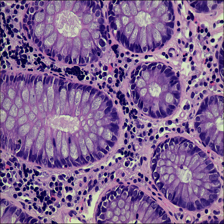

In [40]:
idx = 3
image = batch["original_images"][idx]
Image.fromarray(image)

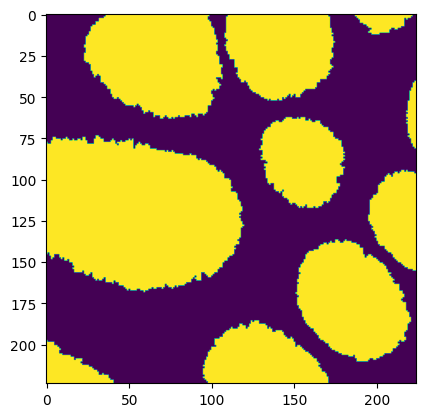

In [41]:
segmentation_map = batch["original_segmentation_maps"][idx]
plt.imshow(segmentation_map)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


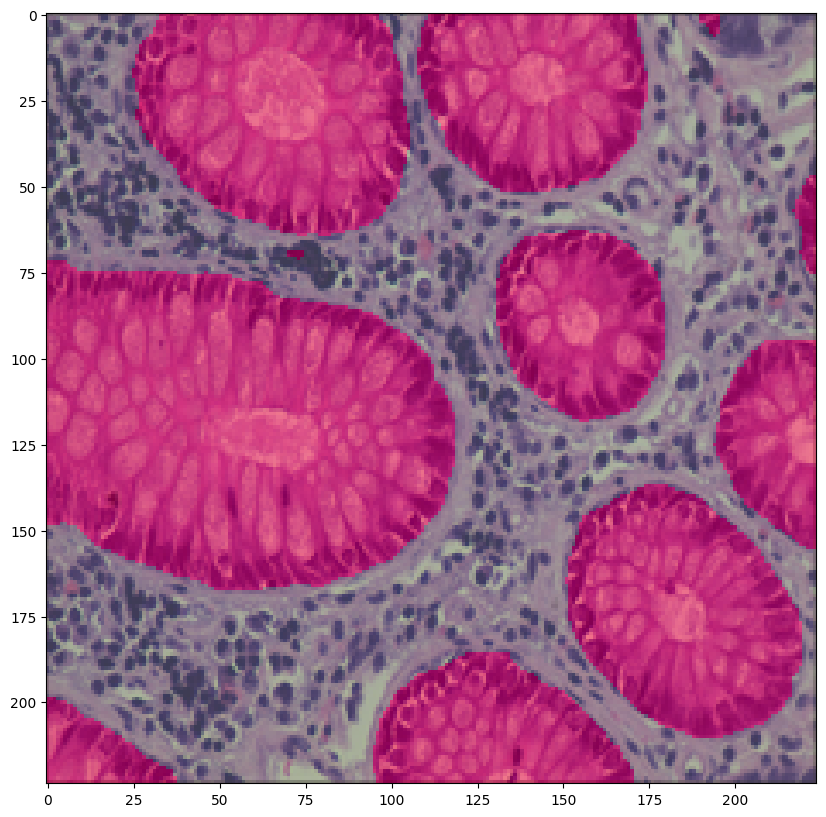

In [42]:
import numpy as np
import matplotlib.pyplot as plt

segmentation_map = predicted_segmentation_maps[idx].cpu().numpy()
print(segmentation_map)
color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in enumerate(palette):
    color_segmentation_map[segmentation_map == label, :] = color
# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]

img = image * 0.5 + ground_truth_color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Compare to the ground truth:

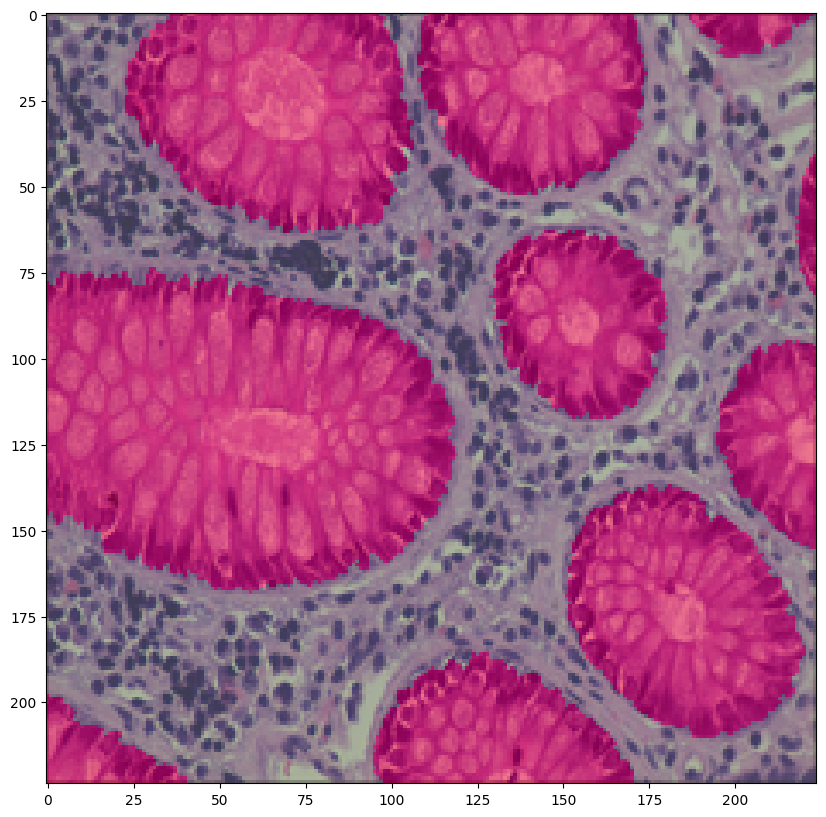

In [43]:
import numpy as np
import matplotlib.pyplot as plt

segmentation_map = batch["original_segmentation_maps"][idx]

color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in enumerate(palette):
    color_segmentation_map[segmentation_map == label, :] = color
# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]

img = image * 0.5 + ground_truth_color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()